# Create a neural network capable of identifying circles
And make it run on a GPU!

In [1]:
import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset, DataLoader
import numpy as np

In [2]:
IMG_SIZE = 100 # All our circles will be in square this many pixels wide

In [3]:
def draw_circle(x,y,rad,size,mark=1):
    """
    Create a binary 2D matrix representation of a circle
    :param x: x coordinate of circle center
    :param y: y coordinate of circle center
    :param rad: radius of circle
    :param size: size of the matrix (size x size)
    :return: torch matrix (size x size) with 1s representing the circle
    """
    pic = torch.zeros(size,size)
    for i in range(size):
        for j in range(size):
            dx = i-x
            dy = j-y
            d2 = (dx*dx + dy*dy)
            if abs(d2-(rad * rad)) < 10:
                pic[i,j] = mark
            else:
                pic[i,j] = 0
    return pic   

In [4]:
# Create a 2D representation of a circle, radius 10 at (30,30)
circ30 = draw_circle(30, 30, 10, IMG_SIZE)

In [5]:
circ30 # Output of draw_circle is a 2D array of mostly 0s

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

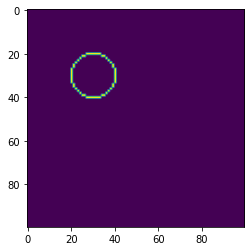

In [6]:
plt.imshow(circ30) # Here's a visual representation of our circle

In [7]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        
        self.net = nn.Sequential(
            nn.Conv2d(
                in_channels  = 1,
                padding      = 0,
                out_channels = 32, # may change?
                kernel_size  = 4  # may change
            ),
            nn.BatchNorm2d(32),
            nn.Conv2d(
                in_channels  = 32,
                padding      = 0,
                out_channels = 5, # may change?
                kernel_size  = 9  # may change
            ),
            nn.Flatten(),
            nn.Linear(5 * (97 - 8) * (97 - 8), 2048),
            nn.ReLU(),
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, 3),
            nn.ReLU()
        )

        ###size = 301088        
        ###self.linear_relu_stack = nn.Sequential(
        ###    nn.Linear(size, 2048),
        ###    nn.ReLU(),
        ###    nn.Linear(2048, 512),
        ###    nn.ReLU(),
        ###    nn.Linear(512, 3),
        ###    nn.ReLU()
        ###)

    def forward(self, our_data):
        ###x21 = self.conv_stage_1(our_data)
        ###x2 = self.conv_stage_2(x21)
        #### x2 = self.flatten(x1)
        #### logits = self.linear_relu_stack(x2)
        #### return logits
        ###x3 = self.flatten(x2)
        ###x4 = self.linear_relu_stack(x3)
        ###return x4
        x = self.net(our_data)
        return(x)

In [8]:
net = NeuralNetwork() # Create an instance of our neural network class, name it "net"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Get the cuda device
print(device)
net.to(device)

cuda:0


NeuralNetwork(
  (net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv2d(32, 5, kernel_size=(9, 9), stride=(1, 1))
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=39605, out_features=2048, bias=True)
    (5): ReLU()
    (6): Linear(in_features=2048, out_features=512, bias=True)
    (7): ReLU()
    (8): Linear(in_features=512, out_features=3, bias=True)
    (9): ReLU()
  )
)

In [9]:
# Massage circ30 (a 2D array of mostly 0s and some 1s representing a circle) into something we can use
net_input = circ30.unsqueeze(0).unsqueeze(0)

Note: According to https://stackoverflow.com/a/59566009 Conv2D and many other layers expect input conforming to (n_samples, channels, height, width) # e.g., (1000, 1, 224, 224)

So the two unsqueezes above simply pad the input with 1 sample dimension and 1 channel dimension [100, 100] -> [1, 1, 100, 100]

Also, unsqueeze seems like it's helpful for hacking stuff together early on - it just adds a dimension at the specified index

In [10]:
net_input.shape # Our network input is of shape [1, 1, 100, 100]

torch.Size([1, 1, 100, 100])

In [11]:
ans = net(net_input.to(device)) # Run input through the network - No training being done here, just one forward pass

In [12]:
ans.shape # Show the shape of our network output

torch.Size([1, 3])

In [13]:
ans

tensor([[0.0000, 0.0000, 0.0315]], device='cuda:0', grad_fn=<ReluBackward0>)

# Create Training Data for Classifying Circles
### We already have a circle function draw_circle(), so we just need to utilize it to create a bunch of circles matched with their radius and origin
Following https://pytorch.org/tutorials/beginner/data_loading_tutorial.html for the below steps on how to add custom data and datasets and manipulate them via a Dataloader.

### Create a custom dataset to hold our training data
##### Dataset class
torch.utils.data.Dataset is an abstract class representing a dataset. Your custom dataset should inherit Dataset and override the following methods  
* \_\_len__ so that len(dataset) returns the size of the dataset.  
* \_\_getitem__ to support the indexing such that dataset[i] can be used to get iith sample.

In [14]:
class CircleDataset(Dataset):
    def __init__(self, num_circles=10000, r_min=5, r_max=20, size=100):
        randomlist=[] # List of circles generated somewhat randomly based on position and radius
        truthlist=[] # Cooresponding position and radius data for the generated circles
        for i in range(num_circles):
            radius = random.randint(r_min, r_max)
            x = random.randint(radius,size-radius)
            y = random.randint(radius,size-radius)
            c = draw_circle(x,y,radius,size).unsqueeze(0)
            # Recall tensors fed through our network must have a "channels" dimension, in this case it's one, so we will use unsqueeze again to add it
            # If we had e.g. Red, Green, and Blue data, we would split that into three 100x100 channels
            # "single" is chosen here because it seems to be the only numpy type that plays nice with torch.double that are used throughout the network
            truthlist.append(np.array([x,y,radius], dtype=np.single))
            randomlist.append(c)
        self.samples = randomlist # Circles
        self.truth = truthlist # Attributes of those circles
    def __len__(self):
        return len(self.samples)
    def __getitem__(self,idx):
        sample = {'circle': self.samples[idx], 'attributes': self.truth[idx]}
        return sample #(self.samples[idx], self.truth[idx])

In [15]:
dataset = CircleDataset(100) # TODO <- This takes WAY too long to just generate some circles... What gives?

### Using a dataloader allows us to
* Batch the data
* Shuffle the data
* Load the data in parallel using multiprocessing workers.

In [16]:
dataloader = DataLoader(dataset, batch_size=10, shuffle=True, num_workers=0)#, pin_memory=True)
# pin_memory makes CPU/MEM -> GPU/MEM transfers quicker, but may increase memory requirements.

In [17]:
def train():
    import time
    
    #loss_func = nn.functional.cross_entropy # Cross entropy only works for 1D tensors
    #loss_func = nn.L1Loss()
    loss_func = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    
    # initialize empty list to track batch losses
    batch_losses = []
    
    for epoch in range(50):
        
        # Reset Iterator
        dataiter = iter(dataloader)
        
        # Keep track of batch number
        batch_number = 0
        
        # Keep track of time 
        last_time = time.time()
        last_epoch = time.time()
        
        for batch in dataiter:
            batch_number += 1
            
            # Reset Gradients
            optimizer.zero_grad()
            
            # Forward Pass through the network
            out = net(batch["circle"].to(device))
        
            # Calculate loss
            ###print(batch["attributes"][0])
            ###print(out[0])
            loss = loss_func(out, batch["attributes"].to(device)) # Compare our results with the truth data
            
            # track batch loss
            batch_losses.append(loss.item())
            
            # Backpropagate
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Time things
            next_time = time.time()
            delta_time = next_time - last_time
            last_time = next_time
            
            
            """
            # print any stats of the network wrt training progress and loss
            print("Epoch: {}, [{}/{} ({:.0f}%)]\tLoss: {:.6f}, DeltaTime = {}".format(
                str(epoch), # Epoch
                str(batch_number * len(batch["circle"])), # How many samples have we processed
                str(len(dataloader.dataset)), # How many samples are there in total
                100. * batch_number / len(dataloader), # What percentage of this epoch have we processed
                loss.item(),
                delta_time)) # What is the loss for this batch
            """
        # print any stats of the network wrt training progress and loss
        # Time things
        next_epoch = time.time()
        delta_epoch = next_epoch - last_epoch
        last_epoch = next_epoch
        print("Epoch: {}, DeltaTime = {:.2f}, LastLoss = {:.2f}".format(
            str(epoch), # Epoch
            delta_epoch,
            batch_losses[-1])) # What is the loss for this batch            

In [18]:
train()

Epoch: 0, DeltaTime = 0.31, LastLoss = 374.42
Epoch: 1, DeltaTime = 0.21, LastLoss = 598.09
Epoch: 2, DeltaTime = 0.22, LastLoss = 690.55
Epoch: 3, DeltaTime = 0.21, LastLoss = 424.38
Epoch: 4, DeltaTime = 0.21, LastLoss = 221.77
Epoch: 5, DeltaTime = 0.21, LastLoss = 155.02
Epoch: 6, DeltaTime = 0.21, LastLoss = 210.62
Epoch: 7, DeltaTime = 0.21, LastLoss = 139.98
Epoch: 8, DeltaTime = 0.21, LastLoss = 26.66
Epoch: 9, DeltaTime = 0.21, LastLoss = 46.46
Epoch: 10, DeltaTime = 0.21, LastLoss = 14.25
Epoch: 11, DeltaTime = 0.21, LastLoss = 6.90
Epoch: 12, DeltaTime = 0.21, LastLoss = 7.73
Epoch: 13, DeltaTime = 0.21, LastLoss = 6.29
Epoch: 14, DeltaTime = 0.21, LastLoss = 3.00
Epoch: 15, DeltaTime = 0.21, LastLoss = 5.17
Epoch: 16, DeltaTime = 0.21, LastLoss = 1.11
Epoch: 17, DeltaTime = 0.21, LastLoss = 1.68
Epoch: 18, DeltaTime = 0.21, LastLoss = 0.69
Epoch: 19, DeltaTime = 0.21, LastLoss = 0.69
Epoch: 20, DeltaTime = 0.21, LastLoss = 1.93
Epoch: 21, DeltaTime = 0.21, LastLoss = 1.56
E

In [19]:
def check_circle_network(network):
    radius = random.randint(4, 20)
    x = random.randint(radius,100-radius)
    y = random.randint(radius,100-radius)
    circle = draw_circle(x,y,radius,100).unsqueeze(0).unsqueeze(0)
    ans = network(circle.to(device))
    print("For circle at ({}, {}), r={}, net guessed:\n{}".format(str(x), str(y), str(radius), str(ans)))
    truth = draw_circle(x, y, radius, IMG_SIZE, 0.2)
    guess = draw_circle(int(ans[0][0]), int(ans[0][1]), int(ans[0][2]), IMG_SIZE)
    return (truth + guess)

In [20]:
def check_network_splatter(network, num_checks=10):
    plt.figure()
    num_cols = 5
    num_rows = int((num_checks / num_cols) + (1 if (num_checks % num_cols) == 0 else 0))
    fig = plt.figure(figsize=(20,10))#f, canvas = plt.subplots(num_rows, num_cols)
    for check in range(num_checks):
        #canvas[check].imshow(check_circle_network(network))
        fig.add_subplot(num_rows, num_cols, check + 1) # + 1 because range is 0-indexed but pyplot is 1-indexed
        plt.imshow(check_circle_network(network))


For circle at (30, 36), r=15, net guessed:
tensor([[26.5731, 33.9438, 14.6016]], device='cuda:0', grad_fn=<ReluBackward0>)
For circle at (62, 77), r=18, net guessed:
tensor([[50.3321, 62.5564, 11.2293]], device='cuda:0', grad_fn=<ReluBackward0>)
For circle at (48, 31), r=18, net guessed:
tensor([[33.8621, 22.1693, 10.2998]], device='cuda:0', grad_fn=<ReluBackward0>)
For circle at (57, 44), r=18, net guessed:
tensor([[40.3423, 31.6440, 10.4257]], device='cuda:0', grad_fn=<ReluBackward0>)
For circle at (40, 41), r=17, net guessed:
tensor([[26.9466, 28.1801, 11.2756]], device='cuda:0', grad_fn=<ReluBackward0>)
For circle at (47, 26), r=13, net guessed:
tensor([[48.7826, 26.8389, 15.2976]], device='cuda:0', grad_fn=<ReluBackward0>)
For circle at (44, 56), r=14, net guessed:
tensor([[34.4994, 44.8433, 10.4453]], device='cuda:0', grad_fn=<ReluBackward0>)
For circle at (74, 85), r=13, net guessed:
tensor([[68.9615, 77.1361,  9.3288]], device='cuda:0', grad_fn=<ReluBackward0>)
For circle at (3

<Figure size 432x288 with 0 Axes>

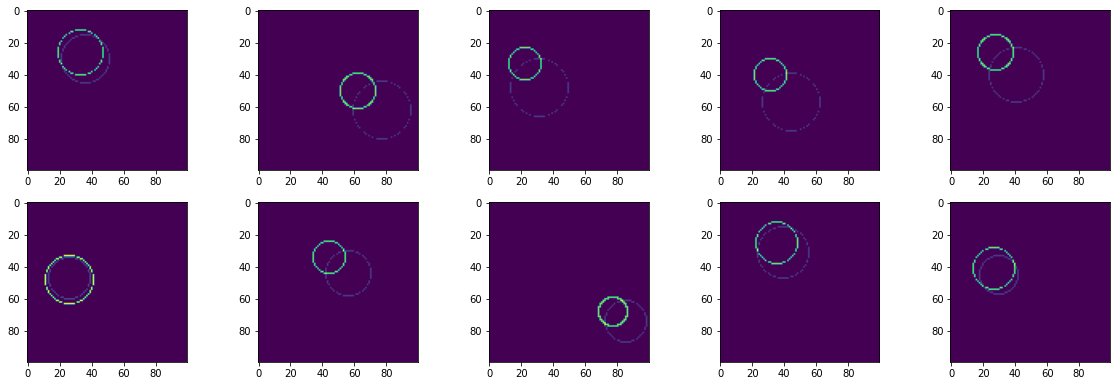

In [21]:
check_network_splatter(net)

In [22]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  645786 KB |    1878 MB |  497305 MB |  496674 MB |
|       from large pool |  645425 KB |    1878 MB |  496803 MB |  496173 MB |
|       from small pool |     361 KB |       1 MB |     501 MB |     501 MB |
|---------------------------------------------------------------------------|
| Active memory         |  645786 KB |    1878 MB |  497305 MB |  496674 MB |
|       from large pool |  645425 KB |    1878 MB |  496803 MB |